# Challenge: Evaluate Your Sentiment Classifier

It's time to revisit your classifier from the previous assignment. Using the evaluation techniques we've covered here, look at your classifier's performance in more detail. Then go back and iterate by engineering new features, removing poor features, or tuning parameters. Repeat this process until you have five different versions of your classifier. Once you've iterated, answer these questions to compare the performance of each:

- Do any of your classifiers seem to overfit?
- Which seem to perform the best? Why?
- Which features seemed to be most impactful to performance?

Write up your iterations and answers to the above questions in a few pages. Submit a link below and go over it with your mentor to see if they have any other ideas on how you could improve your classifier's performance.

In [1]:
import scipy
import sklearn
import string

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn import metrics
from sklearn.model_selection import KFold
from scipy import stats

plt.style.use("default")
sns.set(style="whitegrid")

In [32]:
# Load the data from imdb_labelled.txt into a pandas dataframe
file_path = "sentiment labelled sentences\imdb_labelled.txt"

imdb_raw = pd.read_csv(file_path, delimiter="\t", header=None)
imdb_raw.columns = ["reviews","sentiment_score"]

In [63]:
# No need to search for word candidates as they were set in the first Challenge assignment
# Words to match on in the data
keywords = ["best", "good", "loved", "very", "perfect", "greatest", "perfect", "10", "decent", "terrific", "fun", "beautiful"]

for key in set(keywords):
    imdb_raw[str(key)] = imdb_raw["reviews"].str.contains(" "+str(key)+" ", case=False)

# Convert the sentiment_score to boolean values
imdb_raw["sentiment_score"] = (imdb_raw["sentiment_score"]==1)

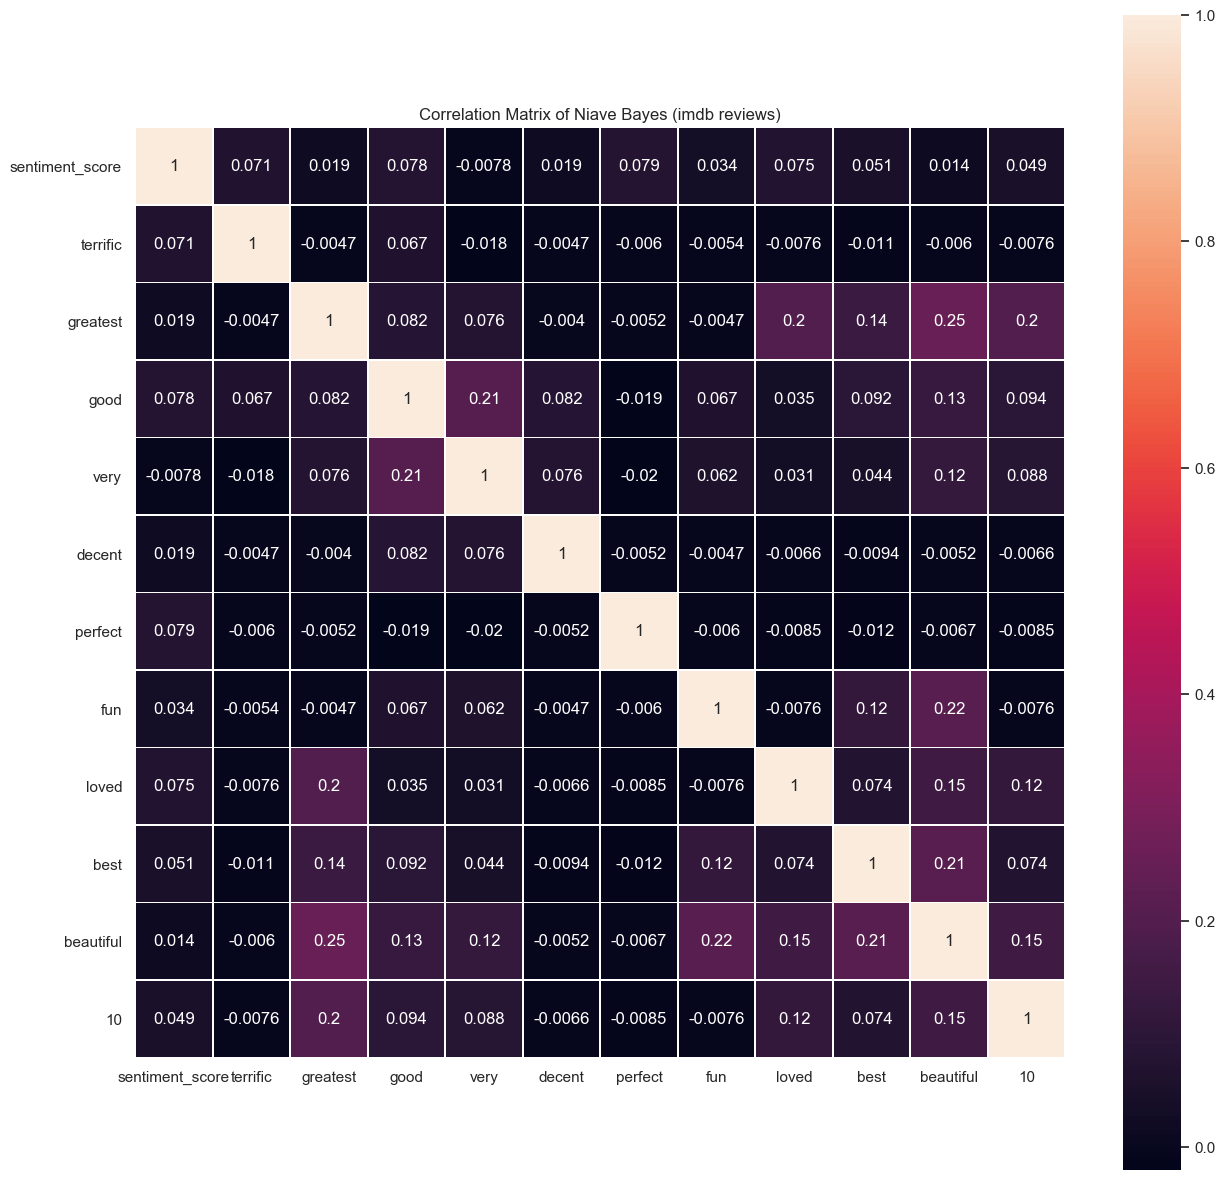

In [34]:
# Visual variable independence 
def corr_plot(corr_mat,figsize,title):
    """
        Pass in a correlation matrix and figsize (as a tuple) and plot the corresponding heatmap.
    """
    plt.figure(figsize=figsize)

    sns.heatmap(corr_mat, square=True, annot=True, linewidth=0.5)
    plt.title(title)

    # Fix display issues for this version of matplotlib
    b,t = plt.ylim()
    b += 0.5
    t -= 0.5
    plt.ylim(b,t)
    # plt.yticks(rotation=360)

    plt.show();

# imdb_raw.dropna(axis=1,how="any",inplace=True)
corr_plot(corr_mat=imdb_raw.corr(),figsize=(15,15),title=f"Correlation Matrix of Niave Bayes (imdb reviews)")

In [89]:
def train_and_test(X,y,splits):
    # Instantiate the model and store in a variable
    bnb = BernoulliNB()

    # Set the number of folds (training and test samples) 
    kf = KFold(n_splits=splits)

    score_lists = list()

    i=0
    # Train and test using the KFolds
    for train_index, test_index in kf.split(X):
        # print("TRAIN:", train_index, "TEST:", test_index)        
        i+=1
        # Create the train samples from the fold
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]

        # Create the test samples from the fold
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Locate the appropriate rows in the target series
        train_ref = y.iloc[train_index]

        # Train the model using the train and test data
        y_pred_train = bnb.fit(X_train, y_train).predict(X_train)

        # Create a Confusion Matrix to report on model training
        train_confusion = dict(
            false_positives=((~train_ref)&(y_pred_train)).sum(),
            false_negatives=((train_ref)&(~y_pred_train)).sum(),
            y_pred_correct_pos=((train_ref)&(y_pred_train)).sum(),
            y_pred_correct_neg=((~train_ref)&(~y_pred_train)).sum(),
            target_pos=(train_ref).sum(),
            target_neg=(~train_ref).sum(),
            sensitivity=(((train_ref)&(y_pred_train)).sum()/(train_ref).sum())*100,     
            specificity=(((~train_ref)&(~y_pred_train)).sum()/(~train_ref).sum())*100, 
            total_errors=(train_ref != y_pred_train).sum()
        )

        # Locate the appropriate rows in the target series
        test_ref = y.iloc[test_index]

        # Train the model using the train and test data
        y_pred_test = bnb.fit(X_test, y_test).predict(X_test)

        # Create a Confusion Matrix to report on model training
        test_confusion = dict(
            false_positives=((~test_ref)&(y_pred_test)).sum(),
            false_negatives=((test_ref)&(~y_pred_test)).sum(),
            y_pred_correct_pos=((test_ref)&(y_pred_test)).sum(),
            y_pred_correct_neg=((~test_ref)&(~y_pred_test)).sum(),
            target_pos=(test_ref).sum(),
            target_neg=(~test_ref).sum(),
            sensitivity=(((test_ref)&(y_pred_test)).sum()/(test_ref).sum())*100,     
            specificity=(((~test_ref)&(~y_pred_test)).sum()/(~test_ref).sum())*100, 
            total_errors=(test_ref != y_pred_test).sum()
        )
        

        # Generate a report of model training
        print(f"""Fold {i}:
    Training Total Errors: {train_confusion["total_errors"]}, False Negatives: {train_confusion["false_negatives"]}, False Positives: {train_confusion["false_positives"]}, Sensitivity: {train_confusion["sensitivity"]:,.4f}% Specificity: {train_confusion["specificity"]:,.4f}%
    Test Total Errors: {test_confusion["total_errors"]}, False Negatives: {test_confusion["false_negatives"]}, False Positives: {test_confusion["false_positives"]}, Sensitivity: {test_confusion["sensitivity"]:,.4f}% Specificity: {test_confusion["specificity"]:,.4f}%
    Testing on Sample: {(bnb.fit(X_test, y_test).score(X_test, y_test)*100):,.4f}%
    """)

        score_lists.append([train_confusion["total_errors"], train_confusion["false_negatives"], train_confusion["false_positives"], 
            train_confusion["sensitivity"], train_confusion["specificity"], test_confusion["total_errors"], test_confusion["false_negatives"], 
            test_confusion["false_positives"], test_confusion["sensitivity"], test_confusion["specificity"], bnb.fit(X_train, y_train).score(X_train, y_train)*100, 
            bnb.fit(X_test, y_test).score(X_test, y_test)*100])

    return score_lists 

X = imdb_raw[keywords] # x for BernoulliNP.fit()
y = imdb_raw["sentiment_score"] # y for BernoulliNP.fit() 
splits = 5

train_and_test(X,y,splits);

Fold 1:
    Training Total Errors: 263, False Negatives: 9, False Positives: 254, Sensitivity: 97.2644% Specificity: 5.5762%
    Test Total Errors: 51, False Negatives: 51, False Positives: 0, Sensitivity: 10.5263% Specificity: 100.0000%
    Testing on Sample: 66.0000%
    
Fold 2:
    Training Total Errors: 287, False Negatives: 16, False Positives: 271, Sensitivity: 94.8718% Specificity: 5.2448%
    Test Total Errors: 53, False Negatives: 52, False Positives: 1, Sensitivity: 29.7297% Specificity: 98.6842%
    Testing on Sample: 64.6667%
    
Fold 3:
    Training Total Errors: 272, False Negatives: 3, False Positives: 269, Sensitivity: 99.0881% Specificity: 0.0000%
    Test Total Errors: 52, False Negatives: 51, False Positives: 1, Sensitivity: 10.5263% Specificity: 98.9247%
    Testing on Sample: 65.3333%
    
Fold 4:
    Training Total Errors: 257, False Negatives: 242, False Positives: 15, Sensitivity: 15.9722% Specificity: 95.1768%
    Test Total Errors: 51, False Negatives: 0, Fa

In [116]:
all_results = list()
for col in imdb_raw.columns[2:]: 
    imdb_ref = imdb_raw.copy()
    imdb_ref.drop([col],axis=1,inplace=True)

    keywords_copy = keywords.copy()
    keywords_copy = list(set(keywords_copy))
    keywords_copy.remove(col)

    X = imdb_ref[keywords_copy] # x for BernoulliNP.fit()
    y = imdb_ref["sentiment_score"] # y for BernoulliNP.fit() 
    splits = 5

    print(f"Removing: {col}")

    # removed = [col]
    results = train_and_test(X,y,splits)

    for i in range(len(results)):
        all_results.append([col]+results[i])

Removing: terrific
Fold 1:
    Training Total Errors: 263, False Negatives: 9, False Positives: 254, Sensitivity: 97.2644% Specificity: 5.5762%
    Test Total Errors: 53, False Negatives: 53, False Positives: 0, Sensitivity: 7.0175% Specificity: 100.0000%
    Testing on Sample: 64.6667%
    
Fold 2:
    Training Total Errors: 287, False Negatives: 16, False Positives: 271, Sensitivity: 94.8718% Specificity: 5.2448%
    Test Total Errors: 54, False Negatives: 53, False Positives: 1, Sensitivity: 28.3784% Specificity: 98.6842%
    Testing on Sample: 64.0000%
    
Fold 3:
    Training Total Errors: 272, False Negatives: 3, False Positives: 269, Sensitivity: 99.0881% Specificity: 0.0000%
    Test Total Errors: 52, False Negatives: 51, False Positives: 1, Sensitivity: 10.5263% Specificity: 98.9247%
    Testing on Sample: 65.3333%
    
Fold 4:
    Training Total Errors: 259, False Negatives: 244, False Positives: 15, Sensitivity: 15.2778% Specificity: 95.1768%
    Test Total Errors: 51, Fals

In [117]:
col_names = ["removed", "train_total_errors", "train_false_neg", "train_false_pos", "train_sensitivity", 
    "train_specificity", "test_total_errors", "test_false_neg", "test_false_pos", "test_sensitivity", 
    "test_specificity","train_score","test_score"]
df = pd.DataFrame(all_results, columns=col_names)
df

,removed,train_total_errors,train_false_neg,train_false_pos,train_sensitivity,train_specificity,test_total_errors,test_false_neg,test_false_pos,test_sensitivity,test_specificity,train_score,test_score
0,terrific,263,9,254,97.264438,5.576208,53,53,0,7.017544,100.000000,56.020067,64.666667
1,terrific,287,16,271,94.871795,5.244755,54,53,1,28.378378,98.684211,52.006689,64.000000
2,terrific,272,3,269,99.088146,0.000000,52,51,1,10.526316,98.924731,54.515050,65.333333
3,terrific,259,244,15,15.277778,95.176849,51,0,51,100.000000,0.000000,56.761269,65.771812
4,terrific,245,232,13,18.881119,95.846645,49,0,49,100.000000,0.000000,59.098497,67.114094
5,greatest,263,9,254,97.264438,5.576208,51,51,0,10.526316,100.000000,56.020067,66.000000
6,greatest,287,16,271,94.871795,5.244755,53,52,1,29.729730,98.684211,52.006689,64.666667
7,greatest,271,2,269,99.392097,0.000000,53,52,1,8.771930,98.924731,54.682274,64.666667
8,greatest,259,244,15,15.277778,95.176849,51,0,51,100.000000,0.000000,56.761269,65.771812
9,greatest,244,231,13,19.230769,95.846645,49,0,49,100.000000,0.000000,59.265442,67.114094


In [57]:
imdb_raw.columns

Index(['reviews', 'sentiment_score', 'terrific', 'greatest', 'good', 'very',
       'decent', 'perfect', 'fun', 'loved', 'best', 'beautiful', '10'],
      dtype='object')